In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import time

### `generate_dataset`

#### Parameters:
- `n_samples`: Number of data points.
- `n_true_predictors`: Number of effective features.
- `n_non_effective_predictors`: Number of noise features.

#### Steps:

1. **Generate Predictors**:  
   **True Predictors**: `n_true_predictors` arrays of random values.  
   **Non-effective Predictors**: `n_non_effective_predictors` arrays of random values.

2. **Define Coefficients and Intercept**:  
   `beta_0`: Intercept (3.0).  
   `true_coefficients`: Random values (3.5 to 8) for true predictors.

3. **Generate Error Term**:  
   Random noise from a standard normal distribution.

4. **Generate Outcome Variable (`y`)**:  
   Calculated as the sum of the intercept, true predictors multiplied by their coefficients, and the error term.

5. **Combine Predictors into a DataFrame**:  
   Creates a DataFrame with predictors and the outcome variable `y`.

6. **Return**:  
   The DataFrame and true coefficients.

In [61]:
def generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors):
    np.random.seed(8)
    
    # Generate true predictors
    true_predictors = [np.random.rand(n_samples, 1) for _ in range(n_true_predictors)]
    
    # Generate non-effective predictors
    non_effective_predictors = [np.random.rand(n_samples, 1) for _ in range(n_non_effective_predictors)]
    
    # Define the true coefficients and intercept
    beta_0 = 3.0
    true_coefficients = np.random.uniform(2, 10, size=n_true_predictors)
    
    # Generate the error term
    error = np.random.randn(n_samples, 1)
    
    # Generate the outcome variable
    y = beta_0 + sum(beta * x for beta, x in zip(true_coefficients, true_predictors)) + error
    
    # Combine all predictors into a single DataFrame
    predictors = np.hstack(true_predictors + non_effective_predictors)
    columns = [f'x{i+1}' for i in range(n_true_predictors + n_non_effective_predictors)]
    data = pd.DataFrame(predictors, columns=columns)
    data['y'] = y
    
    return data, true_coefficients

In [62]:
# Generate the dataset
n_samples = 1_000
n_true_predictors = 5
n_non_effective_predictors = 10
data, true_coefficients = generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors)

true_coefficients

array([2.83254746, 3.08447364, 4.34119098, 3.2972036 , 9.50128631])

In [63]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,y
0,0.873429,0.310902,0.901550,0.427570,0.644761,0.927682,0.874056,0.864666,0.551791,0.286776,0.523609,0.306303,0.396934,0.775304,0.819978,17.203240
1,0.968541,0.841306,0.510928,0.201062,0.052693,0.114822,0.749553,0.548416,0.771135,0.192682,0.943392,0.682031,0.814918,0.666387,0.971178,13.190649
2,0.869195,0.390119,0.622906,0.028553,0.827774,0.170850,0.040186,0.674345,0.037946,0.281376,0.436470,0.985193,0.253046,0.851353,0.551960,17.252597
3,0.530856,0.895533,0.208874,0.460936,0.250281,0.740611,0.512623,0.947328,0.373571,0.178981,0.762821,0.916194,0.954600,0.560111,0.965510,11.065163
4,0.232728,0.098472,0.547106,0.147156,0.500830,0.135312,0.458617,0.542167,0.655390,0.873041,0.935329,0.743461,0.279753,0.490464,0.560004,10.360125


In [64]:
data.shape

(1000, 16)

In [65]:
X = data.drop(columns='y')
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Basic linear model for baseline coeff in order to compare how Lasso changes the coeff

In [66]:
basic_lr = LinearRegression()

# Fit the model to the training data
basic_lr.fit(X_train, y_train)

lr_pred = basic_lr.predict(X_test)

In [67]:
initial_coefficients = basic_lr.coef_
initial_coefficients

array([ 2.70197248e+00,  3.10664777e+00,  4.34091346e+00,  2.99103106e+00,
        9.37980404e+00,  1.35987834e-01, -4.83528363e-02,  8.04217449e-02,
       -2.07097913e-01,  8.56354921e-02, -2.80947579e-02, -1.09486450e-04,
        1.74331715e-02,  1.71068512e-01,  5.75888583e-02])

In [68]:
# Define the Lasso model
lasso = LassoCV(cv=5, random_state=8, n_jobs=-1)  

start_time = time.time()
lasso.fit(X_train, y_train)

best_alpha = lasso.alpha_
print("Optimal alpha:", best_alpha)

Optimal alpha: 0.007859538280706225


In [69]:
lasso_final = Lasso(alpha=best_alpha)

# Fit the final model to the training data
lasso_final.fit(X_train, y_train)

# Predict on test data and time
y_pred = lasso_final.predict(X_test)
end_time = time.time()

In [70]:
# Calculate the mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.9875491077420825


In [71]:
r2 = r2_score(y_test, y_pred)
print(f"R^2 score: {r2}")

R^2 score: 0.9182858440861922


In [72]:
estimation_time = end_time - start_time
print(estimation_time)

0.14948701858520508


In [73]:
lasso_coefficients = lasso_final.coef_
lasso_coefficients

array([ 2.62256907,  3.0200645 ,  4.25695704,  2.90202905,  9.28075247,
        0.06060556, -0.        ,  0.        , -0.11183955,  0.        ,
       -0.        , -0.        ,  0.        ,  0.08448969,  0.        ])

In [74]:
start_time = time.time()

# Create a DataFrame to compare the coefficients
coefficients_df = pd.DataFrame({
    'Feature_Index': np.arange(len(X.columns)),
    'Feature': X.columns,
    'Initial_Coefficients': initial_coefficients,
    'Lasso_Coefficients': lasso_coefficients
})

zero_indices = coefficients_df[coefficients_df['Lasso_Coefficients'] == 0]['Feature_Index']

In [75]:
coefficients_df

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
0,0,x1,2.701972,2.622569
1,1,x2,3.106648,3.020065
2,2,x3,4.340913,4.256957
3,3,x4,2.991031,2.902029
4,4,x5,9.379804,9.280752
5,5,x6,0.135988,0.060606
6,6,x7,-0.048353,-0.000000
7,7,x8,0.080422,0.000000
8,8,x9,-0.207098,-0.111840
9,9,x10,0.085635,0.000000


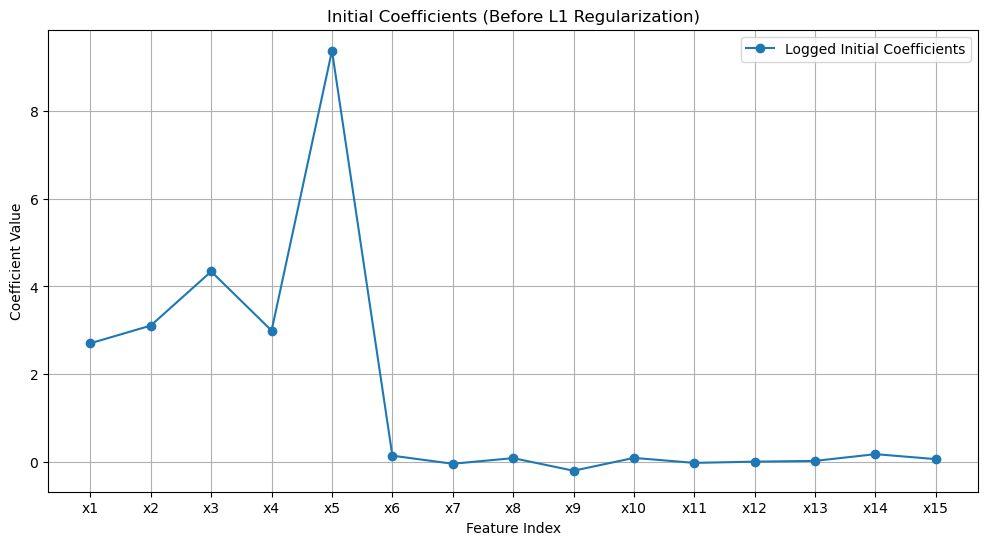

In [76]:
# Plot initial coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature'], coefficients_df['Initial_Coefficients'], marker='o', label='Logged Initial Coefficients', linestyle='-')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Initial Coefficients (Before L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()


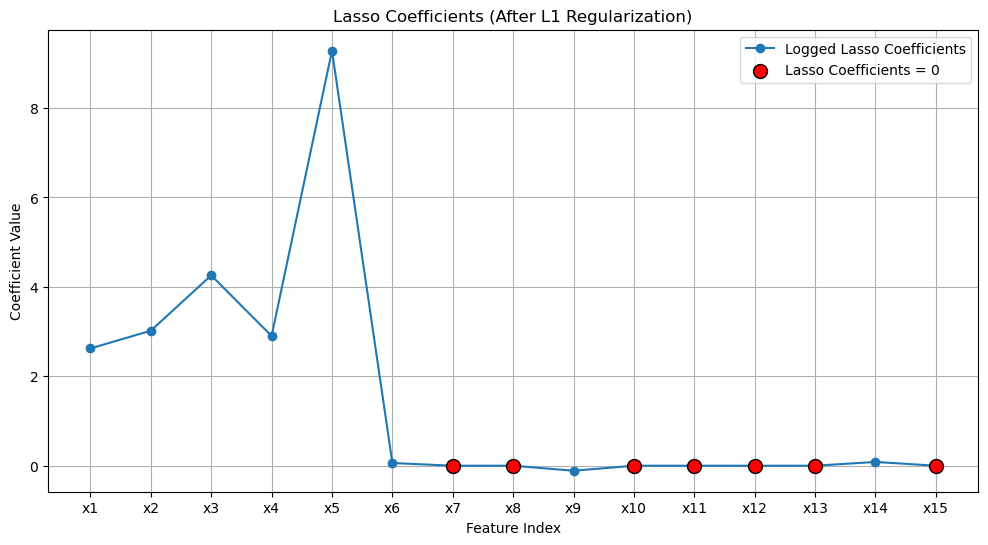

In [77]:
# Plot Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature'], coefficients_df['Lasso_Coefficients'], marker='o', label='Logged Lasso Coefficients', linestyle='-')
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lasso Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
coefficients_df = coefficients_df.sort_values(by="Lasso_Coefficients", ascending=False).reset_index(drop=True)
coefficients_df

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
0,4,x5,9.379804,9.280752
1,2,x3,4.340913,4.256957
2,1,x2,3.106648,3.020065
3,3,x4,2.991031,2.902029
4,0,x1,2.701972,2.622569
5,13,x14,0.171069,0.084490
6,5,x6,0.135988,0.060606
7,6,x7,-0.048353,-0.000000
8,7,x8,0.080422,0.000000
9,9,x10,0.085635,0.000000


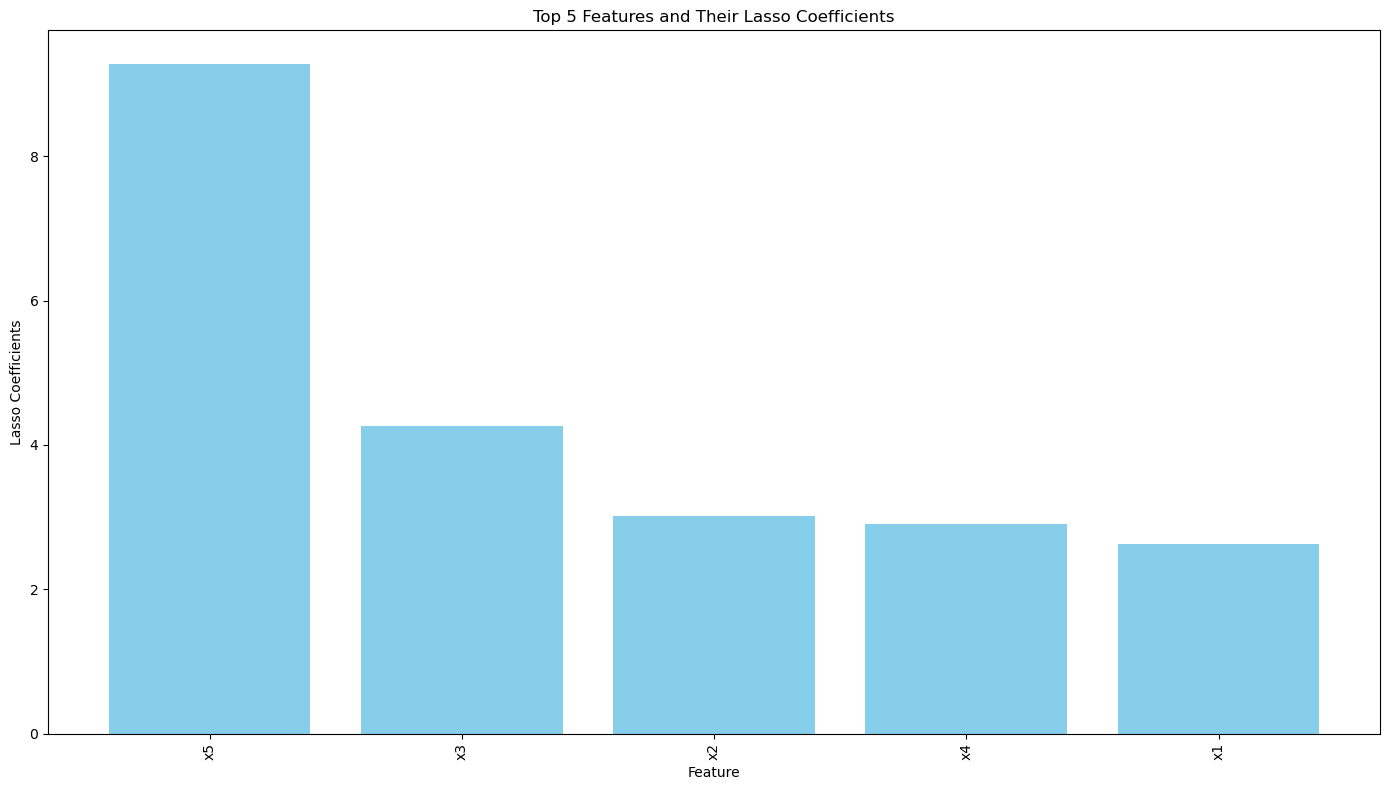

In [79]:
top_5_features = coefficients_df[['Feature', 'Lasso_Coefficients']]
top_5_filtered_df = top_5_features.head(5)

plt.figure(figsize=(14, 8))

plt.bar(top_5_filtered_df['Feature'], top_5_filtered_df['Lasso_Coefficients'], color='skyblue')

plt.xlabel('Feature')
plt.ylabel('Lasso Coefficients')
plt.title('Top 5 Features and Their Lasso Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

end_time = time.time()

In [80]:
explainability_time = end_time - start_time

In [81]:
# Create a DataFrame for the results
results = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred}).reset_index(drop=True)
results

,True Values,Predicted Values
0,10.784186,10.478649
1,9.790402,9.972101
2,8.669460,8.309595
3,12.198899,12.278978
4,13.283112,14.049395
...,...,...
195,14.792494,16.252133
196,14.405954,13.763598
197,15.349697,14.272855
198,20.609995,21.122596


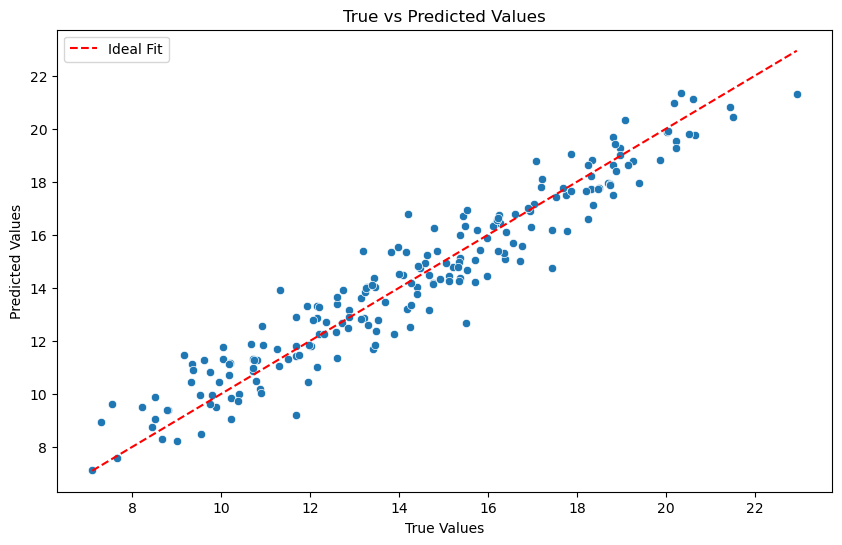

In [82]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=results)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

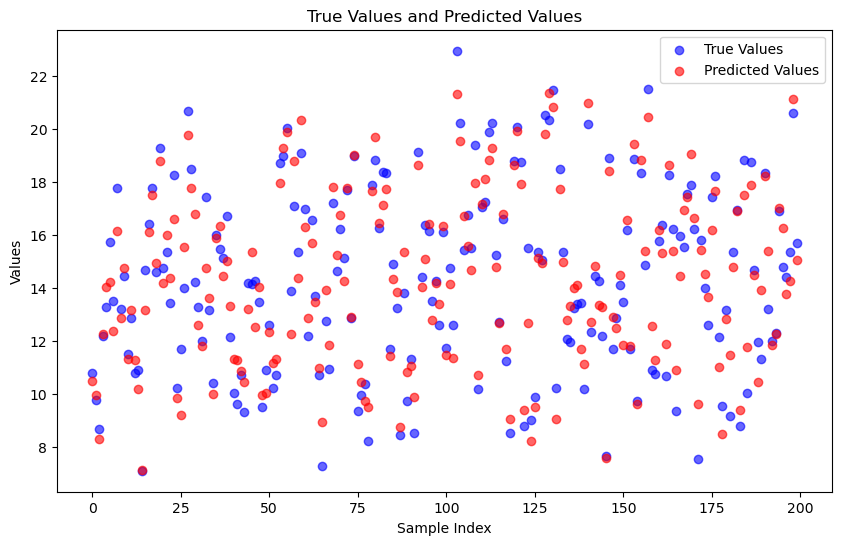

In [83]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.6, label='True Values')
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.6, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('True Values and Predicted Values')
plt.legend()
plt.show()

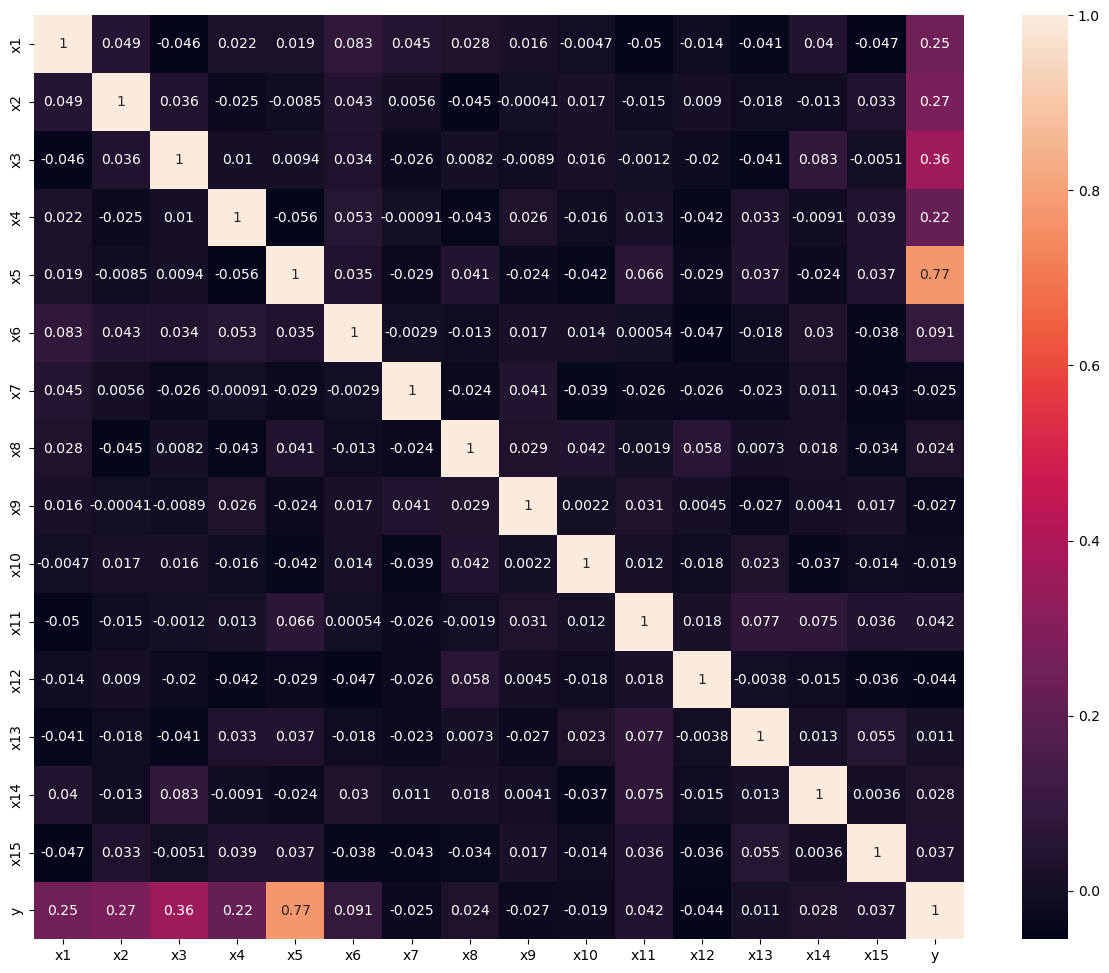

In [84]:
# Exclude non-numeric columns
corrmat = data.corr()

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, annot=True);

In [85]:
# Threshold for identifying multicollinearity
threshold = 0.5

# Find pairs of highly correlated features
high_corr_var = {}
for i in range(len(corrmat.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > threshold:
            colname = corrmat.columns[i]
            if colname not in high_corr_var:
                high_corr_var[colname] = corrmat.columns[j]

print("Highly correlated features (above threshold of {}):".format(threshold))
for key, value in high_corr_var.items():
    print(key, "<--->", value)

Highly correlated features (above threshold of 0.5):
y <---> x5


## shows no multicollinearity in random generated data

# Time to collect result metrics

In [94]:
lasso_metrics = []
# LassoCV model metrics
#fpr, fnr = calculate_fp_fn_rates(cf_matrix)
lasso_metrics.append({
    'Simulation Size': '5-10-1_000',
    'Model': 'Lasso',
    'Inference Time (sec)': round(estimation_time, 3),
    'R Squared': r2,
    'RMSE': rmse,
    'Explanation/Interpretation Task': 'Interpret LASSO',
    'Interpretation Time (sec)': round(explainability_time, 3),
    #'top_5_features': top_5_features_str
    # 'auc': round(roc_auc, 3),
    # 'false_positive_rate': round(fpr, 3),
    # 'false_negative_rate': round(fnr, 3)
})

lasso_metrics_df = pd.DataFrame(lasso_metrics)
lasso_metrics_df

,Simulation Size,Model,Inference Time (sec),R Squared,RMSE,Explanation/Interpretation Task,Interpretation Time (sec)
0,5-10-1_000,Lasso,0.149,0.918286,0.987549,Interpret LASSO,0.849


In [95]:
lasso_metrics_df.to_csv('5-10-1_000-metrics.csv', index=False)